In [1]:
# import Liabrary

In [2]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 
import torch, gc

from torch.optim  import lr_scheduler

from pycocotools.coco import COCO

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':210,
    'LEARNING_RATE':5e-4,
    'BATCH_SIZE':32,
    'SEED':42
}

import wandb

wandb.init(project="pose_estimation_baseline", entity="kimjunsu")

wandb.config = {
  "learning_rate": 5e-4,
  "epochs": 210,
  "batch_size": 32
}

wandb: Currently logged in as: kimjunsu. Use `wandb login --relogin` to force relogin


In [5]:
# seed  fix

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [7]:
train_coco_path = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_train2017.json'
valid_coco_path = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_val2017.json'
coco_train = COCO(valid_coco_path)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [8]:
personIds = coco_train.getCatIds(catNms=['person'])
print(personIds)

[1]


In [9]:
imgIds = coco_train.getImgIds(catIds=personIds)
print(imgIds[0])
print(len(imgIds))

annIds = coco_train.getAnnIds(catIds=personIds,imgIds = imgIds)
print(len(annIds))

anns = coco_train.loadAnns(annIds)
print(len(anns))

#print(anns[0]['keypoints'])
# image id --> 이미지
# category id --> 카테고리 ex. person
# id --> annotation 고유 id


532481
2693
11004
11004


In [10]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, label_path, transforms=None):
        self.image_folder = image_folder
        self.label_paths = label_path
        self.coco = COCO(label_path)
        personIds = self.coco.getCatIds(catNms=['person'])
        self.imgIds = self.coco.getImgIds(catIds=personIds)
        self.annIds = self.coco.getAnnIds(catIds=personIds,imgIds = self.imgIds)

        self.transforms = transforms

    def __getitem__(self, index):
        img_path = f'{self.image_folder}/{self.imgIds[index]}/.jpg'
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.annIds[index]['keypoints']
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        return image, label
        
    
    def __len__(self):
        return len(self.annIds)

In [11]:
# 모델링 단계에서 사용하기
def render_gaussian_heatmap(self, joint_coord):
    x = torch.arange(cfg.output_hm_shape[2]) #64
    y = torch.arange(cfg.output_hm_shape[1]) #64
    z = torch.arange(cfg.output_hm_shape[0])
    zz,yy,xx = torch.meshgrid(z,y,x)
    xx = xx[None,None,:,:,:].cuda().float(); yy = yy[None,None,:,:,:].cuda().float(); zz = zz[None,None,:,:,:].cuda().float();

    x = joint_coord[:,:,0,None,None,None]; y = joint_coord[:,:,1,None,None,None]; z = joint_coord[:,:,2,None,None,None];
    heatmap = torch.exp(-(((xx-x)/cfg.sigma)**2)/2 -(((yy-y)/cfg.sigma)**2)/2 - (((zz-z)/cfg.sigma)**2)/2)
    heatmap = heatmap * 255
    return heatmap

In [12]:
# Augmentation

In [13]:
def transformation(state='train'):
    if state == 'train':
        transform = A.Compose([
                                #A.HorizontalFlip(p=0.2),
                                #A.VerticalFlip(p=0.2),
                                #A.Rotate(p=0.2),
                                #A.RandomRotate90(p=0.2),
                                #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),
                                A.Resize(256,256),
                                A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ToTensorV2(),
                                ])
    else:
        transform = A.Compose([
                            A.Resize(256,256),
                            #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),               
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

    return transform

In [14]:
train_image_Folder = '/home/gsc/mmpose/data/coco/val2017'
train_label = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_train2017.json'
train_transform = transformation('train')
train_dataset = CustomDataset(train_image_Folder, train_label, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=4)

loading annotations into memory...
Done (t=5.49s)
creating index...
index created!


In [15]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, bn_momentum=0.1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, bn_momentum=0.1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class StageModule(nn.Module):
    def __init__(self, stage, output_branches, c, bn_momentum):
        super(StageModule, self).__init__()
        self.stage = stage
        self.output_branches = output_branches

        self.branches = nn.ModuleList()
        for i in range(self.stage):
            w = c * (2 ** i)
            branch = nn.Sequential(
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
            )
            self.branches.append(branch)

        self.fuse_layers = nn.ModuleList()
        # for each output_branches (i.e. each branch in all cases but the very last one)
        for i in range(self.output_branches):
            self.fuse_layers.append(nn.ModuleList())
            for j in range(self.stage):  # for each branch
                if i == j:
                    self.fuse_layers[-1].append(nn.Sequential())  # Used in place of "None" because it is callable
                elif i < j:
                    self.fuse_layers[-1].append(nn.Sequential(
                        nn.Conv2d(c * (2 ** j), c * (2 ** i), kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(c * (2 ** i), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.Upsample(scale_factor=(2.0 ** (j - i)), mode='nearest'),
                    ))
                elif i > j:
                    ops = []
                    for k in range(i - j - 1):
                        ops.append(nn.Sequential(
                            nn.Conv2d(c * (2 ** j), c * (2 ** j), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),
                                      bias=False),
                            nn.BatchNorm2d(c * (2 ** j), eps=1e-05, momentum=0.1, affine=True,
                                           track_running_stats=True),
                            nn.ReLU(inplace=True),
                        ))
                    ops.append(nn.Sequential(
                        nn.Conv2d(c * (2 ** j), c * (2 ** i), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),
                                  bias=False),
                        nn.BatchNorm2d(c * (2 ** i), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    ))
                    self.fuse_layers[-1].append(nn.Sequential(*ops))

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        assert len(self.branches) == len(x)

        x = [branch(b) for branch, b in zip(self.branches, x)]

        x_fused = []
        for i in range(len(self.fuse_layers)):
            for j in range(0, len(self.branches)):
                if j == 0:
                    x_fused.append(self.fuse_layers[i][0](x[0]))
                else:
                    x_fused[i] = x_fused[i] + self.fuse_layers[i][j](x[j])

        for i in range(len(x_fused)):
            x_fused[i] = self.relu(x_fused[i])

        return x_fused

class HRNet(nn.Module):
    def __init__(self, c=48, nof_joints=17, bn_momentum=0.1):
        super(HRNet, self).__init__()

        # Input (stem net)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(64, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)

        # Stage 1 (layer1)      - First group of bottleneck (resnet) modules
        downsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
        )
        self.layer1 = nn.Sequential(
            Bottleneck(64, 64, downsample=downsample),
            Bottleneck(256, 64),
            Bottleneck(256, 64),
            Bottleneck(256, 64),
        )

        # Fusion layer 1 (transition1)      - Creation of the first two branches (one full and one half resolution)
        self.transition1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(256, c, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(256, c * (2 ** 1), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 1), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),
        ])

        # Stage 2 (stage2)      - Second module with 1 group of bottleneck (resnet) modules. This has 2 branches
        self.stage2 = nn.Sequential(
            StageModule(stage=2, output_branches=2, c=c, bn_momentum=bn_momentum),
        )

        # Fusion layer 2 (transition2)      - Creation of the third branch (1/4 resolution)
        self.transition2 = nn.ModuleList([
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(c * (2 ** 1), c * (2 ** 2), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 2), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),  # ToDo Why the new branch derives from the "upper" branch only?
        ])

        # Stage 3 (stage3)      - Third module with 4 groups of bottleneck (resnet) modules. This has 3 branches
        self.stage3 = nn.Sequential(
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
        )

        # Fusion layer 3 (transition3)      - Creation of the fourth branch (1/8 resolution)
        self.transition3 = nn.ModuleList([
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(c * (2 ** 2), c * (2 ** 3), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 3), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),  # ToDo Why the new branch derives from the "upper" branch only?
        ])

        # Stage 4 (stage4)      - Fourth module with 3 groups of bottleneck (resnet) modules. This has 4 branches
        self.stage4 = nn.Sequential(
            StageModule(stage=4, output_branches=4, c=c, bn_momentum=bn_momentum),
            StageModule(stage=4, output_branches=4, c=c, bn_momentum=bn_momentum),
            StageModule(stage=4, output_branches=1, c=c, bn_momentum=bn_momentum),
        )

        # Final layer (final_layer)
        self.final_layer = nn.Conv2d(c, nof_joints, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = [trans(x) for trans in self.transition1]  # Since now, x is a list (# == nof branches)

        x = self.stage2(x)
        # x = [trans(x[-1]) for trans in self.transition2]    # New branch derives from the "upper" branch only
        x = [
            self.transition2[0](x[0]),
            self.transition2[1](x[1]),
            self.transition2[2](x[-1])
        ]  # New branch derives from the "upper" branch only

        x = self.stage3(x)
        # x = [trans(x) for trans in self.transition3]    # New branch derives from the "upper" branch only
        x = [
            self.transition3[0](x[0]),
            self.transition3[1](x[1]),
            self.transition3[2](x[2]),
            self.transition3[3](x[-1])
        ]  # New branch derives from the "upper" branch only

        x = self.stage4(x)

        x = self.final_layer(x[0])

        return x

In [16]:
model = HRNet(32, 17, 0.1)
model.load_state_dict(torch.load('./weights/pose_hrnet_w32_256x192.pth'))

<All keys matched successfully>

In [17]:
model = model.to(device)

y = model(torch.ones(1, 3, 256, 192).to(device))

In [18]:
print(y.shape)

torch.Size([1, 17, 64, 48])


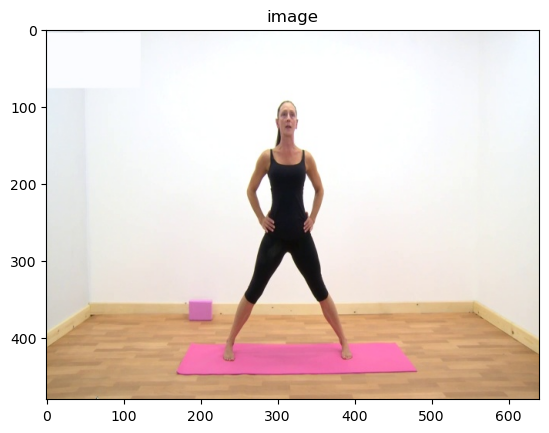

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
img = cv2.imread('/home/gsc/img/100000000101.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('image')
plt.show()

In [27]:
transform = A.Compose([     A.Resize(256,192),
                            #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),               
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])
img = transform(image=img)['image']
img = img.to(device)

In [30]:
img = img.reshape(1,3,256,192)
print(img.shape)

torch.Size([1, 3, 256, 192])


In [42]:
out = model(img)

In [43]:
out.shape

torch.Size([1, 17, 64, 48])

In [45]:
out = out.to('cpu').detach().numpy()

In [46]:
print(out[0][0].shape)

(64, 48)


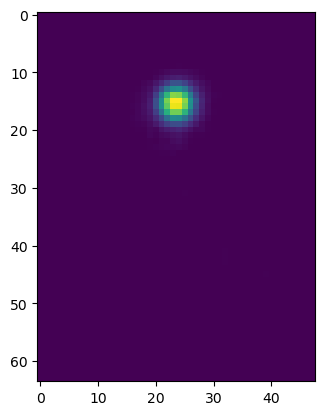

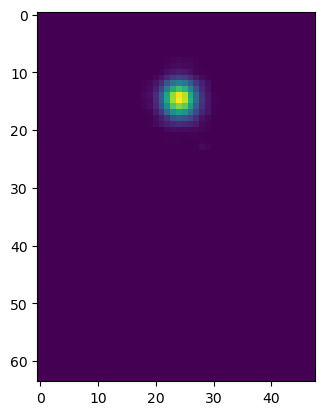

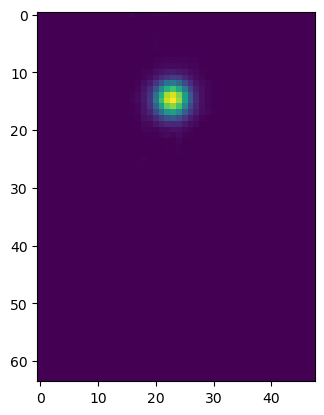

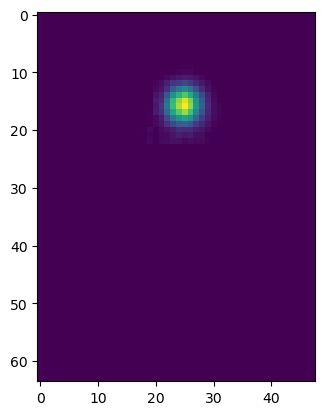

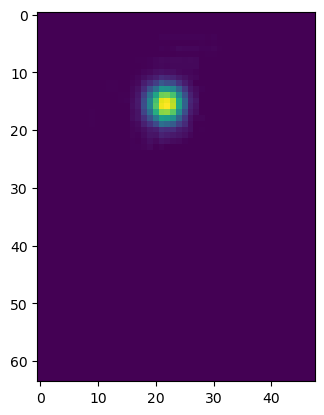

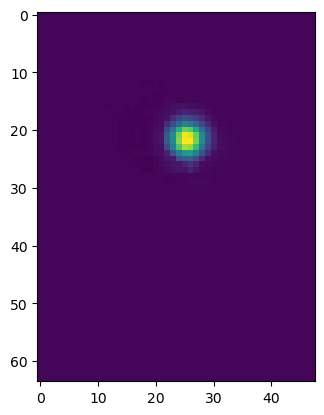

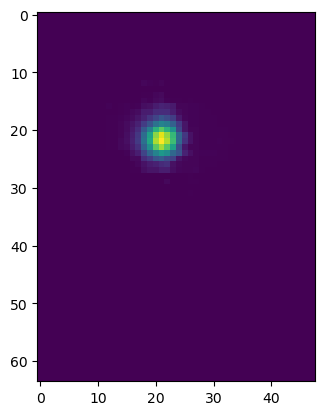

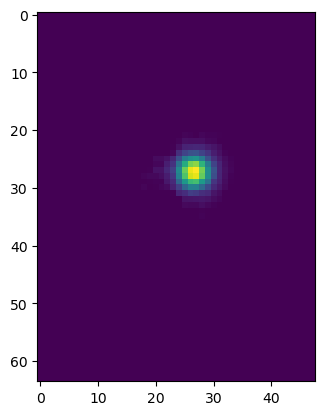

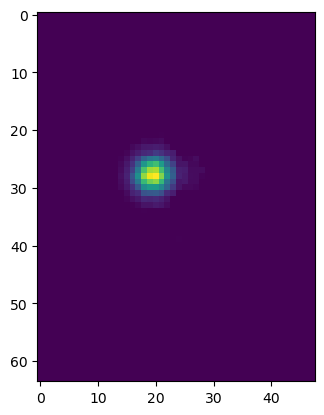

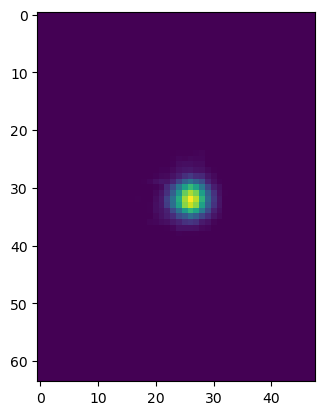

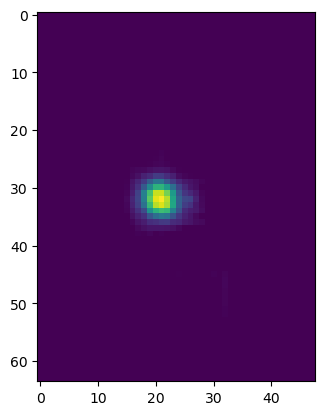

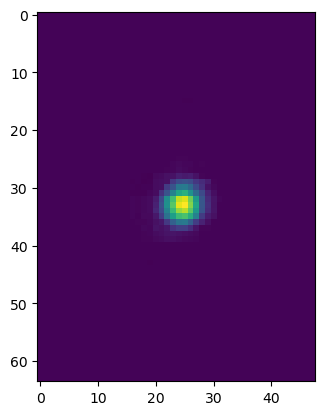

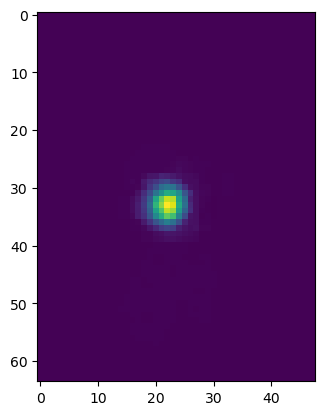

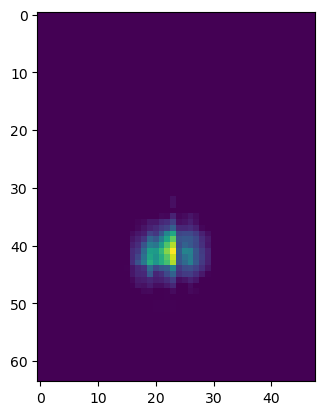

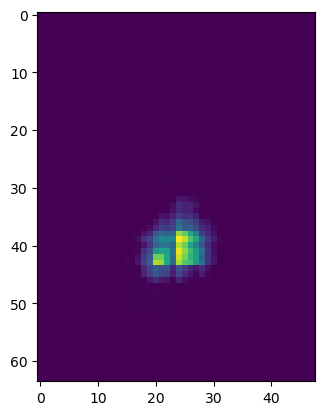

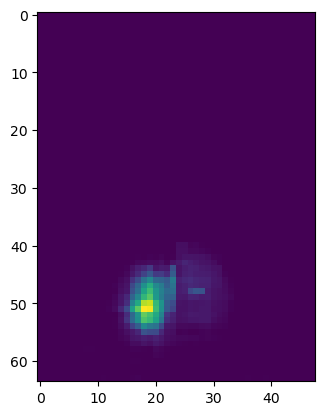

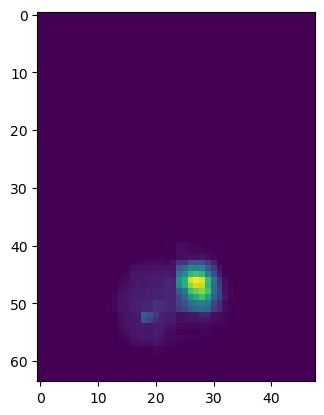

In [62]:
for i in range(17):
    plt.imshow(out[0][i])
    plt.show()

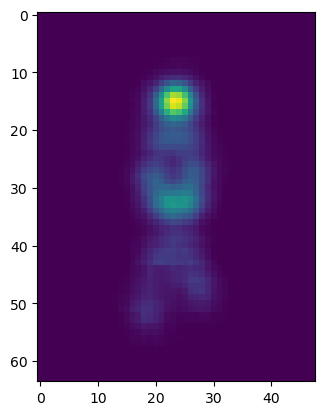

In [63]:
final = np.zeros((64,48))
for i in range(17):
    final = final+out[0][i]
plt.imshow(final)
plt.show()

In [60]:
def train(model,epochs, optimizer, train_loader, test_loader, scheduler, device,weights):
    model.to(device)

    #criterion = nn.CrossEntropyLoss().to(device) 바꾸기 adoptivewingloss
    
    best_score = 0
    best_model = None
    
    for epoch in range(1,epochs+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.type(torch.LongTensor).to(device) # label heatmap으로 바꿔주기
            
            optimizer.zero_grad()

            model_pred = model(img)
            
            loss = criterion(model_pred, label)
            wandb.log({"train_loss": loss})

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        tr_loss = np.mean(train_loss)
            
        val_loss, val_score = validation(model, criterion, test_loader, device)
            
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step()
            
        #if best_score < val_score:
        #    best_model = model
        #    best_score = val_score
        
    return best_model
